In [1]:
import pickle
from itertools import chain

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from src.auxil import plot_estimates, plot_rmse, plot_traj, rmse, rmse_network
from src.kalmanfilter import KalmanFilter
from src.kfnet import KFNet
from src.statespace import CAModel, CVModel, RWModel, StateSpace
from src.trajectory import Trajectory

sns.set_style("white")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Simulation parameters
RUNS = 100
NETWORK_FILE = "./networks/network_15_6.pkl"
FILEPATH_CSV = "./simulations/rwm_cvm_cam/rmse_cvm.csv"
RANDOM_SEED = None

# Trajectory generator parameters
ndat = 1000
q = 9.8e-5  # Process noise intensity
r = 5  # Observation noise std
# q = 10
# r = 1.3
NDIM = 2
TRAJ_MODEL = CAModel(q, r, ndim=NDIM)
INIT_STATE = np.zeros(6)

# Additional filter parameters
c_rwm = 15  # RWM process noise scaling constant
c_cvm = 1
expf = 0.95  # Exponential forgetting param
reset_thresh = 5.0  # Filter reset threshold (Euclidean distance from centroid)

tr = "camtr"

In [4]:
# Generate a trajectory
traj = Trajectory(
    TRAJ_MODEL, n_steps=ndat, init_state=INIT_STATE, R=None, random_seed=RANDOM_SEED
)

# plot_traj(traj)

In [5]:
# No coop nodes
rmse_rwmnc = np.zeros((ndat, NDIM))
rmse_camnc = np.zeros((ndat, NDIM))
rmse_cvmnc = np.zeros((ndat, NDIM))
rmse_data = np.zeros((ndat, 3 * NDIM))

# Run simulations
for i in range(RUNS):
    ###
    rwmnc = KalmanFilter(RWModel(q, r, ndim=NDIM))
    cvmnc = KalmanFilter(CVModel(q, r, ndim=NDIM))
    camnc = KalmanFilter(CAModel(q, r, ndim=NDIM))

    # Add observation noise for each node
    traj.simulate(ndat, INIT_STATE)
    traj.add_obs_noise(R=False)

    # Run estimation
    for yt in traj.observations:
        rwmnc.predict()
        rwmnc.update(yt, log=True)

        cvmnc.predict()
        cvmnc.update(yt, log=True)

        camnc.predict()
        camnc.update(yt, log=True)

    # Save results
    rmse_rwmnc += rmse(traj.X[:, :NDIM], rwmnc.history[:, :NDIM], n=ndat)
    rmse_cvmnc += rmse(traj.X[:, :NDIM], cvmnc.history[:, :NDIM], n=ndat)
    rmse_camnc += rmse(traj.X[:, :NDIM], camnc.history[:, :NDIM], n=ndat)
#     rmse_data += network_rmse([], traj, ndat, 2, rwmnc, cvmnc, camnc)

In [6]:
# Average the results
rmse_rwmnc /= RUNS
rmse_cvmnc /= RUNS
rmse_camnc /= RUNS
rmse_data /= RUNS

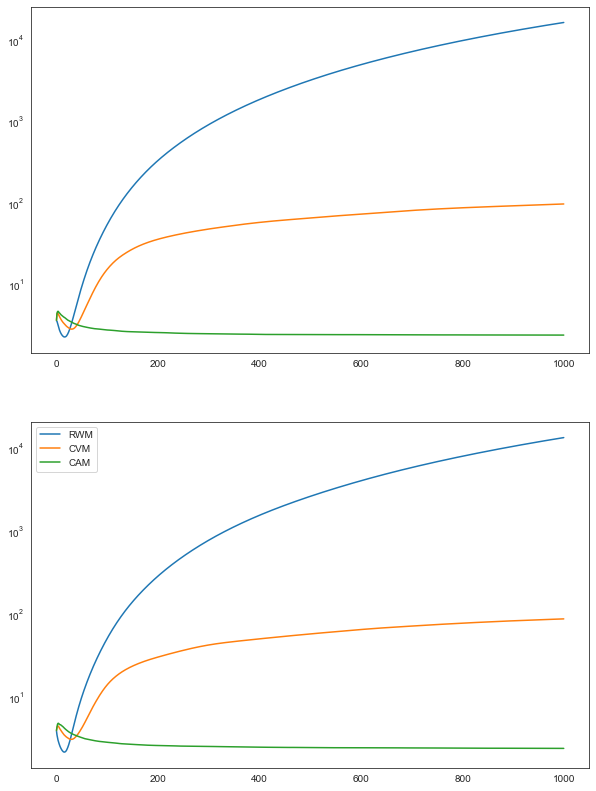

In [7]:
plt.figure(figsize=(10, 14))

for i in range(NDIM):
    plt.subplot(2, 1, i + 1)
    plt.plot(rmse_rwmnc[:, i], label=f"RWM")
    plt.plot(rmse_cvmnc[:, i], label=f"CVM")
    plt.plot(rmse_camnc[:, i], label=f"CAM")

    plt.yscale("log", base=10)

plt.legend()
plt.show()

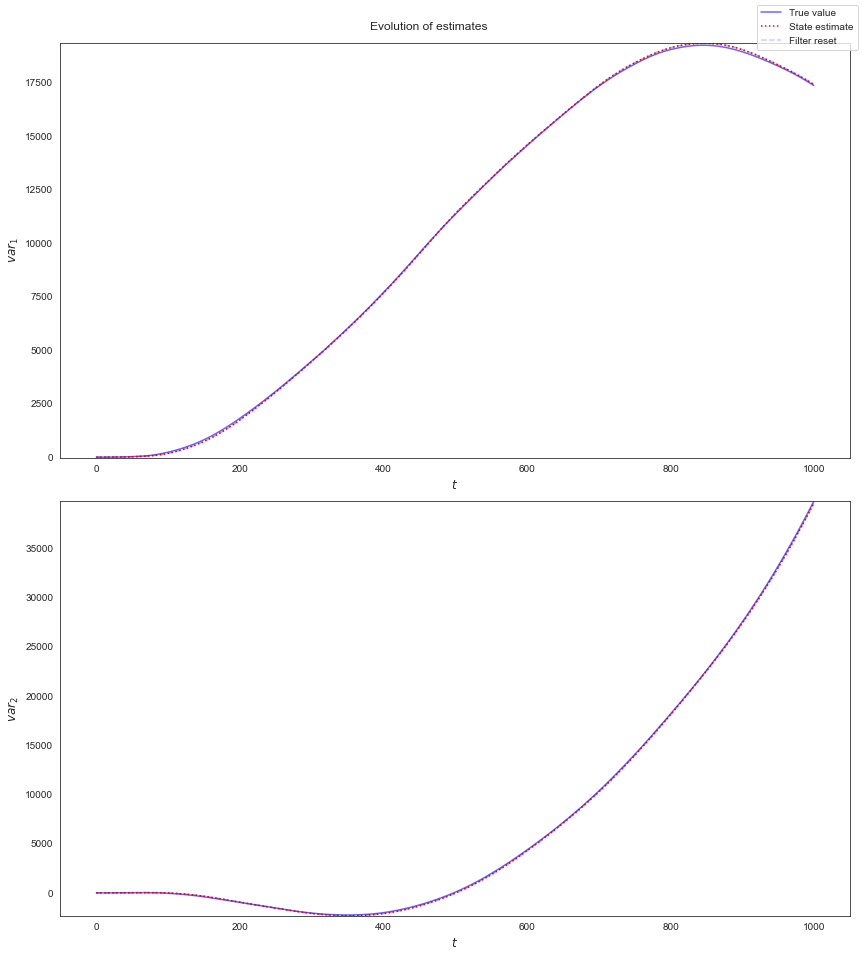

In [8]:
plot_estimates(cvmnc, traj, nvars=2)

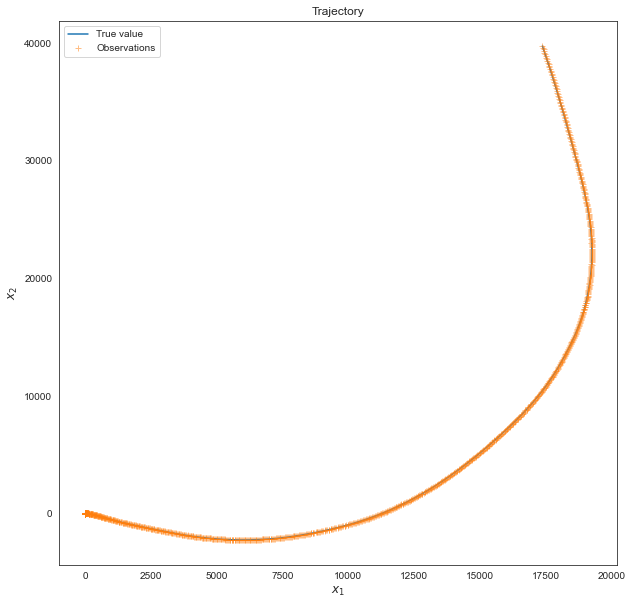

In [9]:
plot_traj(traj, obs=1)

In [10]:
dfs = []
for kf in [rwmnc, cvmnc, camnc]:
    dfs.append(kf.to_dataframe(traj))

In [11]:
fp = "./simulations/rwm_cvm_cam/"
for df, kf in zip(dfs, ["rwm", "cvm", "cam"]):
    n = tr + "_" + kf + ".csv"
#     df.to_csv(fp + n, index_label="t")

In [12]:
# CSV column labels
cols = []
for n in ["RWM", "CVM", "CAM"]:
    for x in ("x1", "x2"):
        cols.append(n + "_" + x)

# Generate CSV files
df = pd.DataFrame(data=rmse_data, columns=cols)
# df.to_csv(FILEPATH_CSV, index_label="t")
df.head()

,RWM_x1,RWM_x2,CVM_x1,CVM_x2,CAM_x1,CAM_x2
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
